<a href="https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/Attention_Flow_Graph_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
# Graph Tool Installation
# https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=GQ18Kd5F3uKe
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

In [ ]:

model_name = 'bert-large-uncased'
from transformers import BertTokenizer, BertForMaskedLM, DistilBertTokenizer, DistilBertModel
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name,
                                  output_hidden_states=True,
                                  output_attentions=True)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import graph_tool as gt
import numpy as np


def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

In [ ]:
sentence = "The author talked to Sara about [MASK] book"
encoded_input = tokenizer(sentence, return_tensors='pt')
# # of tokens: 10 tokens

all_hidden_states, all_attentions = model(**encoded_input)[-2:]

tokens = ['[cls]']+tokenizer.tokenize(sentence)+['[sep]']

# all_attention is a list of tensors, one per layer.
# e.g. Each is (1, 12, 10, 10) which is (batch_size, attention heads, tokens in, tokens out)
_attentions = [att.detach().numpy() for att in all_attentions]

# attentions_mat is cleaner to deal with
# (6, 12, 10, 10) which is (layer, attention head, tokens in, tokens out)
attentions_mat = np.asarray(_attentions)[:,0]


In [ ]:
# Sum the attention values of all the heads, then normalize by dividing by the 
# number of heads
res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]

# Add 1 to each token's attention value to itself.
# This accounts for the residual connection adding the token'the position's
# input back after self-attention
# [None,...] creates
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]


# Normalize so that all the attention going into a node adds up to one?
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

In [ ]:
# We want to end up creating a weighted graph. Turning the attention matrix
# into an adjacency matrix is a step in that direction
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

In [ ]:
# Create the attention graph
g = gt.Graph()
# Set which nodes are connected to which others nodes using tha adjacency matrix
# (No weights/capacities set yet)
indices = res_adj_mat.nonzero()
g.add_edge_list(np.transpose(indices))

# Set the capacities (attention weights)
edge_capacities = g.new_edge_property("double")
edge_capacities.a = res_adj_mat [indices]
g.ep['capacity'] = edge_capacities

In [ ]:

output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)


In [ ]:

from graph_tool.flow import edmonds_karp_max_flow

labels_to_index = res_labels_to_index
length=attentions_mat.shape[-1]
number_of_nodes = len(labels_to_index)
flow_values_gt_2=np.zeros((number_of_nodes, len(input_nodes)))
cap = g.edge_properties["capacity"]

# For each position in each layer
for key in labels_to_index:
    # skip input nodes (attention weights)
    if key not in input_nodes:
        u = labels_to_index[key] # The node we'll trace (source)
        src = g.vertex(u)
        # For each input token
        for inp_node_key in input_nodes:
            v = labels_to_index[inp_node_key] # The input token (target)
            tgt = g.vertex(v)

            # Calculate the maximum flow
            # https://graph-tool.skewed.de/static/doc/flow.html#graph_tool.flow.edmonds_karp_max_flow
            res = edmonds_karp_max_flow(g, src, tgt, cap)
            res.a = cap.a - res.a  # the actual flow
            max_flow = sum(res[e] for e in tgt.in_edges())
            flow_values_gt_2[u][labels_to_index[inp_node_key]] = max_flow

        # Normalize the attention going into the node so it adds up to one    
        flow_values_gt_2[u] /= flow_values_gt_2[u].sum()

In [ ]:
# Attentions are now here:
attention_flow = flow_values_gt_2.reshape((-1, flow_values_gt_2.shape[1], flow_values_gt_2.shape[1]))
print(attention_flow.shape) # Dimensions: Layers, tokens in, tokens out

(25, 10, 10)


In [ ]:
import itertools
import matplotlib.pyplot as plt
def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax

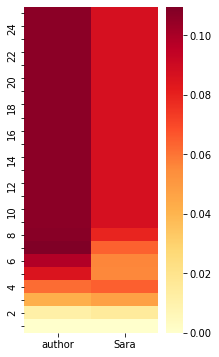

In [ ]:
src = 7
targets = (2,5) 
plt.figure(1,figsize=(3,6))
plot_attention_heatmap(attention_flow, src, targets, sentence)
# (attentions_mat.sum(axis=1)/attentions_mat.shape[1], src, t_positions=targets, sentence=sentence)

In [ ]:
res_att_mat = flow_values_gt_2

params = {'tokens':tokens, 
          'attentions': res_att_mat.tolist()
          }

import json
import datetime
from google.colab import files
time_str = str(int(datetime.datetime.now().strftime("%s")) * 1000 )
filename = 'distilbert_attentions_{}.json'.format(time_str)
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(params, f)

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
flow_values_gt_2[-1]

array([0.03793658, 0.03032572, 0.03233632, 0.0303776 , 0.03035771,
       0.03036755, 0.03120148, 0.03044947, 0.03059527, 0.03101437,
       0.03103461, 0.03037675, 0.03113135, 0.03031724, 0.03068525,
       0.03069881, 0.03176215, 0.03055294, 0.03050438, 0.03054285,
       0.03167248, 0.03051716, 0.03103869, 0.03031635, 0.03069626,
       0.03092836, 0.03058538, 0.03105151, 0.03049016, 0.03289304,
       0.02930562, 0.03793658])

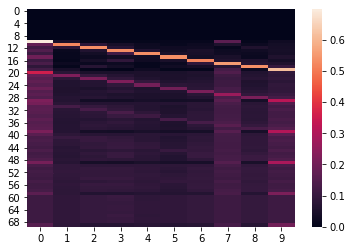

In [ ]:
import seaborn as sns
sns.heatmap(flow_values_gt_2)